# RETRO: Retrieval-Augmented Transformer for Enhanced Contextual Understanding





RETRO (Retrieval-Augmented Transformer) is a cutting-edge model that enhances language processing by splitting input text into chunks and retrieving similar information from a large text database. This approach enriches the context available to the model, significantly improving its performance in tasks such as question answering and text generation. By utilizing pre-trained BERT embeddings, RETRO efficiently pulls in relevant chunks from external data, enhancing the model's contextual understanding without a major increase in size. This method allows RETRO to access extensive knowledge while maintaining lower computational demands compared to larger models.



## Key Features of RETRO



- **Chunked Input Processing**: The model divides input text into manageable chunks, allowing for focused retrieval of relevant information.

- **BERT-Based Retrieval**: Utilizes pre-trained BERT embeddings to identify and retrieve the most relevant chunks from a vast external database.

- **Chunked Cross-Attention**: Integrates retrieved chunks through a chunked cross-attention mechanism, improving predictions while avoiding significant increases in model size.

- **Efficiency in Knowledge Access**: Enhances tasks like question answering and text generation by accessing extensive knowledge bases with lower computational overhead than larger models.



## How RETRO Works



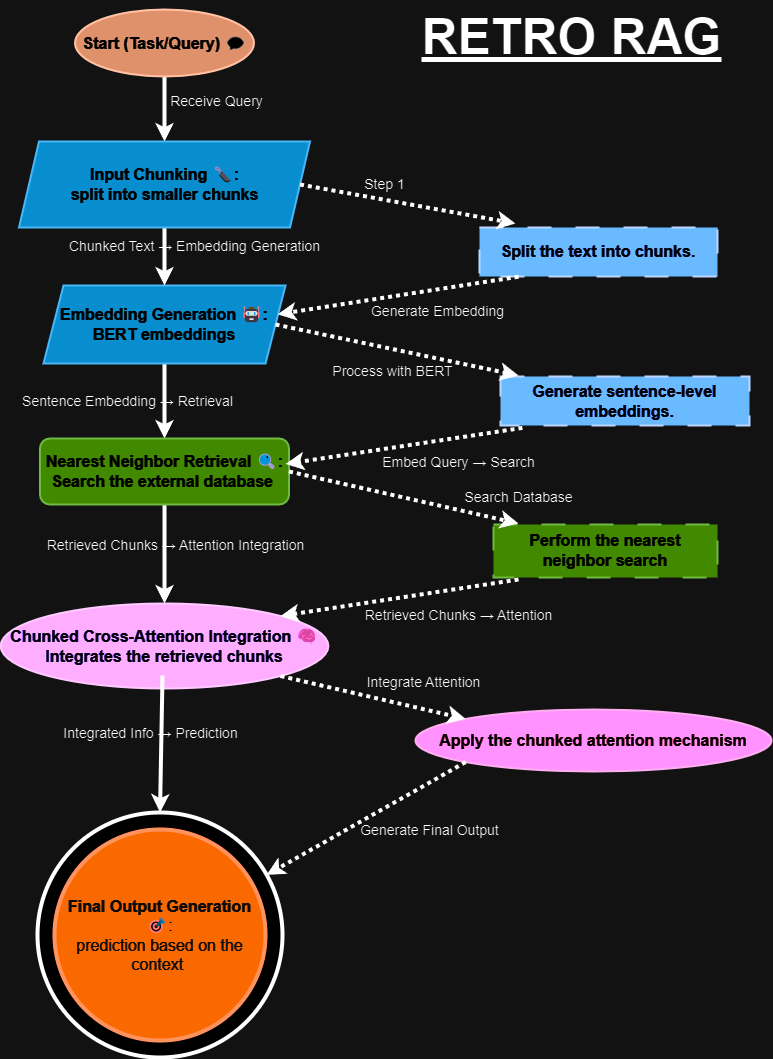

1. **Input Chunking**: When a query is received, RETRO splits the input text into smaller, manageable chunks for processing.

2. **Embedding Generation**:
   - Each chunk is processed through a pre-trained BERT model to generate contextual embeddings.
   - These embeddings are then averaged to create a sentence-level embedding that represents the overall context of the input.

3. **Nearest Neighbor Retrieval**:
   - The sentence embedding is used to perform an approximate nearest neighbor search within an external database.
   - Relevant chunks are retrieved based on their similarity to the input embedding.

4. **Chunked Cross-Attention Integration**:
   - Retrieved chunks are integrated into the processing pipeline through chunked cross-attention mechanisms.
   - This allows the model to attend to both the original input and the retrieved information simultaneously, enhancing context for prediction generation.

5. **Final Output Generation**:
   - The model generates predictions based on both the original input and the integrated retrieved information, resulting in improved accuracy and relevance.



In [ ]:
!pip install pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# Step 0: Initialize the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 1: Download and process the PDF document
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper on Masked Language Models
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 2: Define the query and create an evaluation dataset
query = "What is Transfer Learning from Supervised Data?"
evaluation_dataset = [
    {"query": query, "expected_output": "Information about transfer learning from supervised data in NLP"}
]

In [ ]:
# Step 3: Chunk the document for processing
chunks = [text[i:i + 1000] for i in range(0, len(text), 1000)]  # Divide document into manageable chunks

In [ ]:
# Step 4: Generate Embeddings using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    # Use the [CLS] token embedding for the sentence embedding
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

In [ ]:
# Step 5: Retrieve relevant chunks using Nearest Neighbor Search
chunk_embeddings = [generate_embedding(chunk) for chunk in chunks]
query_embedding = generate_embedding(query)

In [ ]:
# Compute cosine similarity between query and chunks
similarities = cosine_similarity(query_embedding, np.vstack(chunk_embeddings)).flatten()
top_k = 5  # Retrieve the top 5 most relevant chunks
retrieved_chunk_indices = similarities.argsort()[-top_k:][::-1]
retrieved_chunks = [chunks[i] for i in retrieved_chunk_indices]

In [ ]:
print(f"Top retrieved chunks for query '{query}':\n")
for idx, chunk in enumerate(retrieved_chunks, start=1):
    print(f"Chunk {idx}: {chunk[:200]}...\n")  # Display first 200 characters of each chunk

Top retrieved chunks for query 'What is Transfer Learning from Supervised Data?':

Chunk 1: y performs much worse than our
strategy as well....

Chunk 2: tations
have been pre-trained from unlabeled text and
ﬁne-tuned for a supervised downstream task (Dai
and Le, 2015; Howard and Ruder, 2018; Radford
et al., 2018). The advantage of these approaches
is ...

Chunk 3: .
 E1 E2 EN... T1 T2TN...
 E1 E2 EN ... T1 T2 TN...
 E1 E2 EN...Figure 3: Differences in pre-training model architectures. BERT uses a bidirectional Transformer. OpenAI GPT
uses a left-to-right Transf...

Chunk 4: tanding”
We organize the appendix into three sections:
• Additional implementation details for BERT
are presented in Appendix A;• Additional details for our experiments are
presented in Appendix B; an...

Chunk 5: ichard Socher, and Christo-
pher D. Manning. 2014. Glove: Global vectors for
word representation. In Empirical Methods in Nat-
ural Language Processing (EMNLP) , pages 1532–
1543.
Matthew Peters, Wale...


In [ ]:
# Step 6: Chunked Cross-Attention Integration and Output Generation
# Since this involves using cross-attention, we'll integrate the retrieved chunks using attention mechanisms.
# For simplicity, let's assume a model integration approach, similar to RETRO's method.

In [ ]:
# Simulate model behavior for final output generation
module_results = []
for chunk in retrieved_chunks:
    try:
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an advanced assistant that evaluates information retrieval pipelines."},
                {"role": "user", "content": f"Based on the query '{query}' and the retrieved passage:\n{chunk}\nProvide a concise explanation."},
            ],
            model="llama3-8b-8192",
        )
        answer = response.choices[0].message.content
        module_results.append({"chunk": chunk[:200], "answer": answer})  # Store chunk and answer
        print(f"Generated answer: {answer}")
    except Exception as e:
        print(f"Error generating answer: {e}")

Generated answer: It seems like there's been a mistake! The provided passage doesn't match the query, and it doesn't contain any information about transfer learning from supervised data.

A correct answer would involve explaining that transfer learning is a machine learning technique where a model trained on one task is reused as the starting point for training on another task, often with minimal additional training data. In the context of supervised data, transfer learning can help improve performance on new tasks by leveraging the knowledge gained from the original task.

If you'd like, I can provide a concise explanation of transfer learning from supervised data!
Generated answer: Based on the retrieved passage, Transfer Learning from Supervised Data refers to the process of using pre-trained language models on unlabeled text and fine-tuning them for a specific supervised task. This approach has several advantages, including the need to learn fewer parameters from scratch, which all

In [ ]:
# Step 7: Final Output Generation
best_result = max(module_results, key=lambda x: len(x["answer"]))  # Select result with longest answer
print("\nBest result based on module evaluation:")
print(f"Chunk: {best_result['chunk']}\nAnswer: {best_result['answer']}")


Best result based on module evaluation:
Chunk: ichard Socher, and Christo-
pher D. Manning. 2014. Glove: Global vectors for
word representation. In Empirical Methods in Nat-
ural Language Processing (EMNLP) , pages 1532–
1543.
Matthew Peters, Wale
Answer: This passage does not provide a direct answer to the query "What is Transfer Learning from Supervised Data?" However, the passage appears to be a list of references to papers in the field of natural language processing.

In the absence of a direct answer, I can provide a concise explanation of transfer learning from supervised data:

Transfer learning is a machine learning technique where a model trained on one task or dataset is re-purposed to learn another task or dataset. This is typically done by fine-tuning the pre-trained model on the new task or dataset, which can lead to better performance and faster converge than training a new model from scratch. Transfer learning is particularly effective when there is some overlapping inf

In [ ]:
# Final Output: Returning the best answer based on RETRO mechanism
final_output = best_result["answer"]
print("\nFinal Output Generated: ")
print(final_output)


Final Output Generated: 
This passage does not provide a direct answer to the query "What is Transfer Learning from Supervised Data?" However, the passage appears to be a list of references to papers in the field of natural language processing.

In the absence of a direct answer, I can provide a concise explanation of transfer learning from supervised data:

Transfer learning is a machine learning technique where a model trained on one task or dataset is re-purposed to learn another task or dataset. This is typically done by fine-tuning the pre-trained model on the new task or dataset, which can lead to better performance and faster converge than training a new model from scratch. Transfer learning is particularly effective when there is some overlapping information between the source and target tasks or datasets.

In the context of supervised learning, transfer learning can be used when there is a related task or dataset available, such as a downstream task with similar features or l



1. **Initialize the Groq Client:**  
   The Groq client is initialized with the API key, allowing the interaction with the Groq language model to generate responses. This step ensures that we can make requests to Groq's API for generating responses later.

2. **Download PDF Document:**  
   The PDF file is downloaded from the URL (https://arxiv.org/pdf/1810.04805.pdf), which is the paper on BERT (a popular NLP model). The document is saved locally as BERT_paper.pdf to be used in the next step.

3. **Extract Text from PDF:**  
   PyPDF2 is used to open and read the PDF file. The PdfReader class is employed to extract text from each page. This extracted text is concatenated into a single string (text) that holds all the textual content of the paper.

4. **Define the Query:**  
   A query is defined as "What is Transfer Learning from Supervised Data?", which is the question the code will aim to answer from the content of the PDF document. This query will be used to find relevant sections of the paper.

5. **Chunking the Document:**  
   The document text is broken into smaller chunks of 1000 characters each. This makes it easier to process, as processing the entire document at once would be inefficient and cumbersome. The list chunks will contain all the individual text segments that represent different parts of the paper.

6. **BERT Model for Embedding Generation:**  
   The BERT model (specifically bert-base-uncased) and its tokenizer are loaded using the transformers library. A function generate_embedding() is defined, which:
   - Takes a chunk of text (or a query),
   - Tokenizes it into word pieces,
   - Processes it through the BERT model to obtain embeddings,
   - Extracts the [CLS] token's output, which represents the sentence-level embedding of the text.
   These embeddings serve as numerical representations of the text and will later be used to compute similarities.

7. **Generate Embeddings for Chunks and Query:**  
   Each chunk from the document and the query are passed through the generate_embedding() function to obtain their embeddings. These embeddings are stored in chunk_embeddings for the document chunks, and the query_embedding holds the embedding for the user-defined query.

8. **Cosine Similarity Calculation:**  
   The cosine similarity between the query embedding and each of the chunk embeddings is calculated. This measures how similar each chunk is to the query in vector space. Cosine similarity is computed using cosine_similarity() from sklearn, which measures the cosine of the angle between two vectors. Higher cosine similarity means higher relevance to the query.

9. **Retrieve Top-k Relevant Chunks:**  
   The indices of the top-k most relevant chunks are determined by sorting the similarity scores. The top-k chunks (based on the highest cosine similarity) are retrieved and stored in retrieved_chunks. These are the sections of the document that are most likely to contain information relevant to the query.

10. **Generate Answer Using Groq API:**  
    For each of the retrieved chunks, a request is made to Groq's API to generate an answer. The chunk of text is passed to Groq, along with the query, and Groq returns a concise response based on the information in that chunk. The response from Groq is stored in module_results, which contains both the chunk of text and the corresponding generated answer.

11. **Select the Best Answer:**  
    Among all the answers generated for each chunk, the best result is chosen based on the length or quality of the generated answer. In this code, the longest answer (as a proxy for relevance or quality) is selected as the final answer.

12. **Final Output:**  
    The best answer is printed as the final result, which is the response to the query based on the most relevant chunk from the paper.


## Applications of RETRO



- **Open-Domain Question Answering**: Provides accurate answers by leveraging external knowledge effectively, making it suitable for various domains.

- **Content Generation**: Assists writers by generating contextually rich narratives that draw from extensive knowledge bases without relying solely on memorized content.

- **Knowledge Management Systems**: Enhances systems that require up-to-date information retrieval while ensuring accuracy in responses based on comprehensive data access.

- **Educational Tools**: Supports learning applications by providing students with reliable information tailored to their queries with deeper contextual understanding.



## Advantages of RETRO



- **Improved Prediction Accuracy**: By retrieving relevant information, RETRO enhances the accuracy of its predictions, particularly in complex tasks.

- **Reduced Computational Demands**: The chunked processing and retrieval mechanism allows the model to operate efficiently, requiring fewer resources compared to traditional large language models.

- **Scalability**: The architecture can easily scale with additional data without necessitating major changes to the underlying model.

- **Dynamic Knowledge Integration**: RETRO can incorporate real-time updates from its external database, ensuring that it remains current with the latest information.



## Limitations of RETRO



- **Dependence on External Data Quality**: The effectiveness of the model is heavily reliant on the quality and relevance of the retrieved chunks; poor-quality data can lead to inaccuracies.

- **Complexity in Implementation**: Implementing chunked cross-attention and managing retrieval processes may introduce complexity into system design.

- **Latency in Retrieval**: The process of retrieving relevant chunks may introduce some latency, particularly when querying large databases.



## Conclusion



RETRO represents a significant advancement in retrieval-augmented transformer methodologies by effectively integrating external document retrieval into its architecture. Its ability to enhance context through chunked processing and retrieval improves prediction accuracy while maintaining efficiency. As AI continues to evolve, frameworks like RETRO will play an essential role in improving how language models interact with vast amounts of data and provide reliable information.



Having explored RETRO, we will now move on to AUTO RAG.